In [1]:
%run common.ipynb

Tensorflow version: 1.14.0
Keras version: 2.2.4
Numpy version: 1.16.5


Using TensorFlow backend.


In [2]:
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
from collections import OrderedDict
import deeplift
from deeplift.util import compile_func
import sys, os

In [3]:
def percent(background, motif_scores):
    p = 0
    for motif_score in motif_scores:
        idx, scores = motif_score
        mean, std = background[idx]
        score = np.mean(scores)
        
        if score > mean - std and score < mean + std:
            p += 1
    return p/len(motif_scores)

In [4]:
def run_explanations(all_runs):
    percents = {motif : {} for motif in all_motifs}
    output = []

    for keras_model_weights, keras_model_json, testing_data_path, method in all_runs:
        data = load_data(method, testing_data_path)

        model = kc.convert_model_from_saved_files(
                    h5_file=keras_model_weights,
                    json_file=keras_model_json,
                    nonlinear_mxts_mode=NonlinearMxtsMode.DeepLIFT_GenomicsDefault)
        score_func = model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

        background = OrderedDict([('A', 0.3), ('C', 0.2), ('G', 0.2), ('T', 0.3)])

        all_scores = np.zeros((3, data.onehot.shape[0], data.onehot.shape[1]))
        for task_idx in [0,1,2]:
            scores = np.array(score_func(
                        task_idx=task_idx,
                        input_data_list=[data.onehot],
                        input_references_list=[
                         np.array([background['A'],
                                   background['C'],
                                   background['G'],
                                   background['T']])[None,None,:]],
                        batch_size=200,
                        progress_update=None))
            scores = np.sum(scores, axis=2)
            all_scores[task_idx] = scores
        all_scores = np.average(all_scores, axis=0)

        mask = np.zeros(all_scores.shape)
        background = []
        motif_scores = {motif : [] for motif in all_motifs}

        for idx in range(all_scores.shape[0]):
            for embedding in data.embeddings[idx]:
                motif_scores[embedding.what.getDescription()].append(
                    (idx, all_scores[idx, embedding.startPos:embedding.startPos+len(embedding.what)])
                )
                mask[idx, embedding.startPos:embedding.startPos+len(embedding.what)] = 1

            background.append(
                (np.mean(all_scores[idx, np.where(mask[idx] == 0)]), np.std(all_scores[idx, np.where(mask[idx] == 0)]))
                )

        output.append('Background mean: {:.3}, Background std: {:.3}'.format(np.mean(background), np.std(background)))
        
        motif_scores = {key : val for key, val in motif_scores.items() if len(val) != 0}

        for motif, scores in motif_scores.items():
            output.append('Motif: ' + motif)
            output.append('Percent 1 std: {:.2%}'.format(percent(background, scores)))
            for other_motif in motif_scores.keys():
                percents[motif][other_motif] = percent(background, scores)
    return output, percents

In [5]:
import matplotlib.pyplot as plt

def heatmap2d(name, arr: np.ndarray):
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])
    
    plt.imshow(arr, cmap='GnBu')
    plt.colorbar()
#     plt.show()
    plt.savefig(name)

## Percent of motifs fall in background ('and' model)

In [6]:
all_and_runs = []
for i in range(len(all_motifs)):
    for j in range(i + 1, len(all_motifs)):
        m1, m2 = all_motifs[i], all_motifs[j]
        all_and_runs.append(('../model/model_and_' + m1 + '_' + m2 + '.h5', 
             '../model/model_and_' + m1 + '_' + m2 + '.json', 
             '../data/testing_' + m1 + '_' + m2 + '.npy', 
             check_and(m1, m2)))
and_results = run_explanations(all_and_runs)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault

For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale



/home/wenboc/anaconda3/envs/deeplift/lib/python3.7/site-packages/deeplift/conversion/kerasapi_conversion.py:366: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  model_weights = h5py.File(h5_file)


For layer 7 the preceding linear layer is 6 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 10 the preceding linear layer is 9 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel




nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 7 the preceding linear layer is 6 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 10 the preceding linear layer is 9 of type Dense;
In accorda

[[0.         0.00510856 0.00522193 0.01143583 0.00664011]
 [0.01308901 0.         0.24936387 0.02621232 0.06024096]
 [0.02124834 0.30287206 0.         0.07641634 0.45152722]
 [0.01159794 0.0107095  0.20889488 0.         0.02533333]
 [0.00779221 0.00269906 0.99067909 0.02269861 0.        ]]


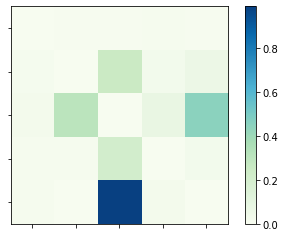

In [8]:
percents = and_results[1]

for motif in all_motifs:
    percents[motif][motif] = 0

all_percents = []
for motif in all_motifs:
    row = []
    for other_motif in all_motifs:
        row.append(percents[motif][other_motif])
    all_percents.append(row)
all_percents = np.array(all_percents)
print(all_percents)
heatmap2d('../fig/and.png', all_percents)

## Percent of motifs fall in background ('or' model)

In [9]:
all_or_runs = []
for i in range(len(all_motifs)):
    for j in range(i + 1, len(all_motifs)):
        m1, m2 = all_motifs[i], all_motifs[j]
        all_or_runs.append(('../model/model_or_' + m1 + '_' + m2 + '.h5', 
             '../model/model_or_' + m1 + '_' + m2 + '.json', 
             '../data/testing_' + m1 + '_' + m2 + '.npy', 
             check_or(m1, m2)))
or_results = run_explanations(all_or_runs)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 7 the preceding linear layer is 6 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 10 the preceding linear layer is 9 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the prece

[[0.         0.00127714 0.00261097 0.00635324 0.00265604]
 [0.01832461 0.         0.00763359 0.03669725 0.0227577 ]
 [0.02788845 0.02219321 0.         0.03293808 0.03984064]
 [0.01030928 0.00669344 0.01212938 0.         0.01733333]
 [0.01038961 0.01079622 0.00399467 0.01008827 0.        ]]


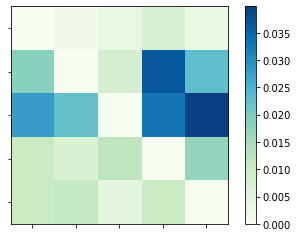

In [10]:
percents = or_results[1]

for motif in all_motifs:
    percents[motif][motif] = 0

all_percents = []
for motif in all_motifs:
    row = []
    for other_motif in all_motifs:
        row.append(percents[motif][other_motif])
    all_percents.append(row)
all_percents = np.array(all_percents)
print(all_percents)
heatmap2d('../fig/or.png', all_percents)

## Percent of motifs fall in background ('single motif' model)

In [11]:
all_single_runs = []
for i in all_motifs:
    all_single_runs.append(('../model/model_single_' + i + '.h5', 
         '../model/model_single_' + i + '.json', 
         '../data/testing_' + i + '.npy', 
         check(i)))

single_results = run_explanations(all_single_runs)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 7 the preceding linear layer is 6 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 10 the preceding linear layer is 9 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the prece

In [12]:
for line in single_results[0]:
    print(line)

Background mean: 0.0138, Background std: 0.0492
Motif: SRF_disc1
Percent 1 std: 0.93%
Background mean: 0.00909, Background std: 0.0311
Motif: AP1_disc1
Percent 1 std: 1.88%
Background mean: 0.0098, Background std: 0.0232
Motif: GATA_disc1
Percent 1 std: 1.62%
Background mean: 0.00868, Background std: 0.0263
Motif: TAL1_known1
Percent 1 std: 0.96%
Background mean: 0.0114, Background std: 0.0288
Motif: IRF_known1
Percent 1 std: 0.47%
